In [1]:
import pandas as pd
import numpy as np
import h5py

# load data
df = pd.read_csv (r'data/raw_data/funding_data.csv')

# replace + and - so they are coded as missing
df = df.replace('+', np.NaN, regex=False)
df = df.replace('-', np.NaN, regex=False)

# Export the pandas DataFrame into HDF5
h5File = "data/cleaned_data/funding_data.hdf5";
df.to_hdf(h5File, "/data/cleaned_data");

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['research_category', '2008', '2009', '2009_ARRA', '2010', '2010_ARRA',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021_Estimated', '2022_Estimated', '2019_US_Mortality_19',
       '2019_US_Prevalence_SE_19'],
      dtype='object')]

  pytables.to_hdf(


In [2]:
# Use pandas again to read data from the hdf5 file to the pandas DataFrame
df = pd.read_hdf(h5File, "/data/cleaned_data");

In [3]:
df 

,research_category,2008,2009,2009_ARRA,2010,2010_ARRA,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021_Estimated,2022_Estimated,2019_US_Mortality_19,2019_US_Prevalence_SE_19
0,Acquired Cognitive Impairment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$798,"$1,132","$1,560","$1,978","$2,423","$2,897","$3,212","$3,307",NaN,NaN
1,Acute Respiratory Distress Syndrome,$82,$103,$17,$110,$22,$96,$98,$95,$85,$108,$103,$107,$123,$126,$158,$159,$146,"10,482",NaN
2,Adolescent Sexual Activity,NaN,NaN,NaN,$80,$7,$69,$76,$70,$68,$85,$91,$99,$96,$102,$88,$92,$104,NaN,NaN
3,Agent Orange & Dioxin,$13,$13,$2,$11,$1,$8,$8,$10,$8,$9,$9,$11,$10,$8,$6,$6,$6,NaN,NaN
4,Aging,"$1,965","$3,015",$554,"$2,517",$443,"$2,572","$2,593","$2,429","$2,556","$2,698","$3,150","$3,572","$4,084","$4,653","$5,276","$5,309","$5,498",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,West Nile Virus,$39,$59,$7,$46,$6,$65,$29,$40,$48,$40,$46,$42,$36,$24,$27,$27,$28,90,NaN
295,Women's Health 8,"$3,514","$3,725",$506,"$3,691",$449,"$3,891","$3,833","$3,745","$3,935","$3,989","$4,540","$4,769","$5,048","$4,469","$4,466","$4,537","$4,779",NaN,NaN
296,Wound Healing and Care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$163,$167,$172,NaN,NaN
297,Youth Violence,$115,$111,$12,$102,$10,$87,$77,$70,$59,$47,$46,$50,$46,$48,$38,$40,$46,NaN,NaN


In [13]:
data2019 = df[["research_category", "2019"]]

#data2019["2019"] = data2019["2019"].apply(lambda x: float(str(x)[1:].replace(",", "")) if x is not None else None)
data2019['2019'] = data2019['2019'].replace('[\$,]', '', regex=True).astype(float)

datatop10 = data2019.sort_values("2019", ascending=False)[:10]
datatop10

/tmp/ipykernel_656/3739999749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2019['2019'] = data2019['2019'].replace('[\$,]', '', regex=True).astype(float)


,research_category,2019
60,Clinical Research,15868.0
114,Genetics,9864.0
225,Prevention,9485.0
188,Neurosciences,9468.0
33,Biotechnology,7219.0
36,Brain Disorders,6954.0
41,Cancer,6520.0
29,Behavioral and Social Science,6499.0
142,Infectious Diseases,6313.0
61,Clinical Trials and Supportive Activities 17,6058.0


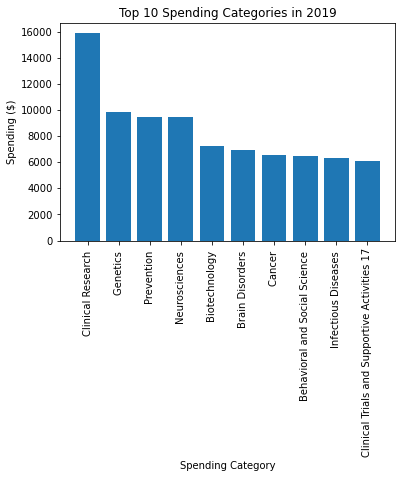

In [19]:
import matplotlib.pyplot as plt

plt.bar(datatop10["research_category"],datatop10["2019"])
plt.xticks(rotation=90)
plt.title("Top 10 Spending Categories in 2019")
plt.xlabel("Spending Category")
plt.ylabel ("Spending ($)");